<a href="https://colab.research.google.com/github/hiya906/my-machine-learning/blob/master/sentimentic_analysis_word2vec_XgBoost_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Library

In [0]:
import nltk
# nltk.download("all")
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
import pandas as pd
from nltk.corpus import stopwords
import re
from gensim.models import Word2Vec
import numpy as np
import xgboost
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

##2. Data Load

In [0]:
train = pd.read_csv('sample_data/train.csv')
test = pd.read_csv('sample_data/test.csv')

## 3. 데이터 개수 확인하기

In [4]:
a = train["airline_sentiment"].to_list()
index, count = np.unique(a, return_counts=True)
print(index)
print(count)

b = test["airline_sentiment"].to_list()
index, count = np.unique(b, return_counts=True)
print(index)
print(count)

['negative' 'neutral' 'positive']
[8254 2797 2125]
['negative' 'neutral' 'positive']
[924 302 238]



## 4. 데이터 시각화하기

(13176,)


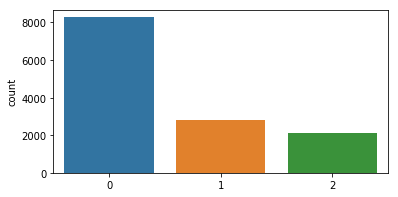

In [5]:
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

le = preprocessing.LabelEncoder()
seniment_num = le.fit_transform(train["airline_sentiment"]) # Label에 자동으로 알아서 번호 매겨줌
print(seniment_num.shape)

fig, e = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(seniment_num)

## 5. Tweet 길이에 대한 통계값

In [6]:
train_length = train["text"].apply(len)

print('트윗 길이 최대값: {}'.format(np.max(train_length)))
print('트윗 길이 평균값: {}'.format(np.mean(train_length)))
print('트윗 길이 표준편차: {}'.format(np.std(train_length)))
print('트윗 길이 중간값: {}'.format(np.median(train_length)))
print('트윗 길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('트윗 길이 제3사분위: {}'.format(np.percentile(train_length, 75)))

트윗 길이 최대값: 186
트윗 길이 평균값: 103.71174863387978
트윗 길이 표준편차: 36.29367249847811
트윗 길이 중간값: 114.0
트윗 길이 제1사분위: 77.0
트윗 길이 제3사분위: 136.0


## 6. 데이터 Word Cloud로 표현해보기

(-0.5, 799.5, 599.5, -0.5)

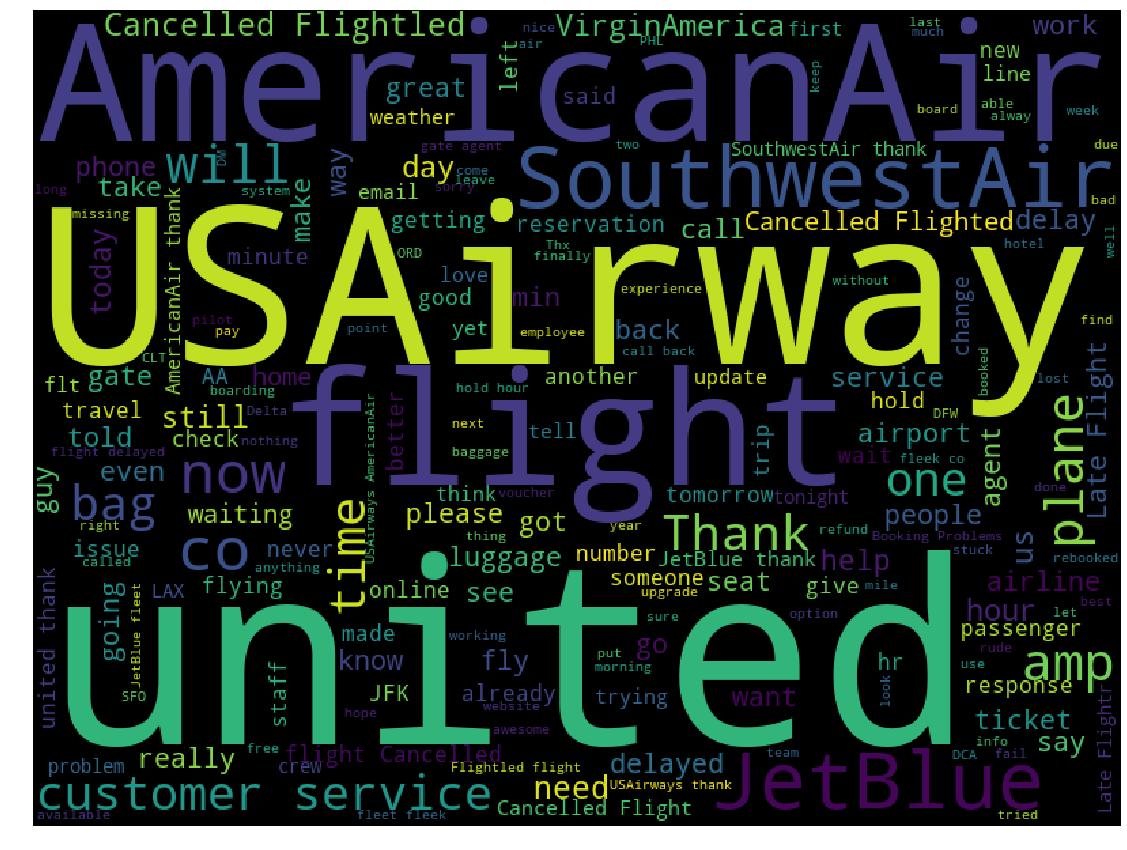

In [7]:
cloud = WordCloud(width=800, height=600).generate(" ".join(train["text"].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

##7. Tweet 길이에 따른 분포표 그리기

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

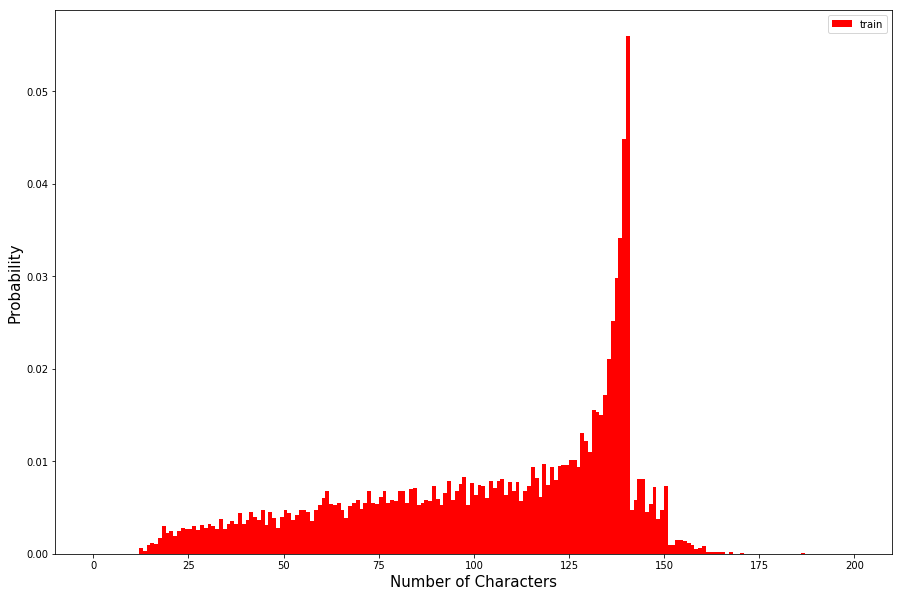

In [8]:
train_length = train["text"].apply(len)
plt.figure(figsize=(15,10))
plt.hist(train_length, bins=200, range=[0, 200], facecolor='r', normed=True, label='train')
plt.legend()
plt.xlabel('Number of Characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## 8. 문장을 토큰으로 분리하기 (word2vec 사용)

In [0]:
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
stopwords_english = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
lemm=WordNetLemmatizer()
def tokenize_row(row):
  row["text"] = re.sub(r'#', '', row["text"])
  row["text"] = re.sub(r'@', '', row["text"])
  row["text"] = re.sub(r'https?:\/\/.*[\r\n]*', '', row["text"])
  tknzr = TweetTokenizer(preserve_case=False) #preserve_case=True, strip_handles=True, reduce_len=True
  text_tokenize = tknzr.tokenize(row["text"])
  row["tokenized_text"] = text_tokenize
  
#   #stem
#   text_clean = []
#   for word in text_tokenize:
#     if (word not in stopwords_english):
#       stem_word = stemmer.stem(word)
#       text_clean.append(stem_word)
#   row['stemed_text'] = text_clean
  
  #lemm
  text_clean = []
  for word in text_tokenize:
    if (word not in stopwords_english):
      stem_word = lemm.lemmatize(word)
      text_clean.append(stem_word)
  row['lemmed_text'] = text_clean
  return row

In [10]:
train = train.apply(tokenize_row, axis=1)
test = test.apply(tokenize_row, axis=1)
print(train.shape)
print(test.shape)
print(train['tokenized_text'].head(5))
print(test['tokenized_text'].head(5))
print(train['lemmed_text'].head(5))
print(test['lemmed_text'].head(5))

(13176, 17)
(1464, 17)
0    [united, yes, i, did, ., we, headed, out, to, ...
1    [americanair, missing, a, full, days, of, work...
2    [usairways, your, mobile, app, is, horrible, !...
3    [americanair, checked, in, on, app, since, yes...
4    [united, we, have, tried, to, change, our, fli...
Name: tokenized_text, dtype: object
0    [southwestair, you're, my, early, frontrunner,...
1    [usairways, how, is, it, that, my, flt, to, ew...
2    [jetblue, what, is, going, on, with, your, bdl...
3    [jetblue, do, they, have, to, depart, from, wa...
4    [jetblue, i, can, probably, find, some, of, th...
Name: tokenized_text, dtype: object
0    [united, yes, ., headed, de-ice, 5, minute, se...
1    [americanair, missing, full, day, work, thanks...
2    [usairways, mobile, app, horrible, !, need, ma...
3    [americanair, checked, app, since, yesterday, ...
4    [united, tried, change, flight, three, time, p...
Name: lemmed_text, dtype: object
0    [southwestair, early, frontrunner, best, a

In [11]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

total_moment = []
for i in train["lemmed_text"]:
  total_moment.append(i)
  
for i in test["lemmed_text"]:
  total_moment.append(i)
  
print(total_moment)
word2vec_model = Word2Vec(train["lemmed_text"], size=300, window=3)
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec_model.intersect_word2vec_format(fname=EMBEDDING_FILE, binary=True)

#word2vec_model = Word2Vec(total_moment, size=512)
# word2vec_model = Word2Vec(train["stemed_text"], size=512)
print(word2vec_model.wv.vocab)

--2019-07-17 08:47:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.69|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

[['united', 'yes', '.', 'headed', 'de-ice', '5', 'minute', 'sent', '.', 'made', 'austin', ',', 'waiting', 'luggage', '.'], ['americanair', 'missing', 'full', 'day', 'work', 'thanks', 'guy'], ['usairways', 'mobile', 'app', 'horrible', '!', 'need', 'major', 'overhaul'], ['americanair', 'checked', 'app', 'since', 'yesterday', '.', 'confirmed', 'upgrade', '&', 'carry', ',', 'got', 'counter', '&', 'manager', 'upgraded', 'somebody', 'else', 'seat', '!'], ['united', 'tried', 'change', 'flight', 'three', 'time', 'phone', 'got', 'disconnected', 'time', '.'], ['decision', 'decision', 'mandarinjourney', 'united', ':',

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


{'united': <gensim.models.keyedvectors.Vocab object at 0x7f710b81ca58>, 'yes': <gensim.models.keyedvectors.Vocab object at 0x7f710b81c3c8>, '.': <gensim.models.keyedvectors.Vocab object at 0x7f71111b1f28>, 'headed': <gensim.models.keyedvectors.Vocab object at 0x7f7109701940>, 'de-ice': <gensim.models.keyedvectors.Vocab object at 0x7f7109701860>, '5': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e6a0>, 'minute': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e748>, 'sent': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e630>, 'made': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e6d8>, 'austin': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e668>, ',': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e710>, 'waiting': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e7b8>, 'luggage': <gensim.models.keyedvectors.Vocab object at 0x7f710b81e5f8>, 'americanair': <gensim.models.keyedvectors.Vocab object at 0x7f710b7eba90>, 'missing': <gensim.m

In [12]:
# print(train_moment)
print(len(total_moment))
print(len(train["lemmed_text"]))
print(word2vec_model)

14640
13176
Word2Vec(vocab=2749, size=300, alpha=0.025)


In [0]:
def get_vector(word):
  if word not in word2vec_model.wv.vocab:
    return None
  return word2vec_model.wv.syn0[word2vec_model.wv.vocab[word].index]

In [14]:
#rows = []
rows=np.zeros((len(total_moment),300),dtype=float)
i=0
for tokens in total_moment:
  current_word2vec = []
  for _, word in enumerate(tokens):
    vec = get_vector(word.lower())
    if vec is not None:
      current_word2vec.append(vec)
  averaged_word2vec = np.array(current_word2vec).mean(axis=0)
  #rows.append(averaged_word2vec)
  rows[i]=averaged_word2vec
  i+=1
  #print(averaged_word2vec)
  
# print(rows)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

rowLen = len(train['lemmed_text'])

dataArray=rows[:rowLen]
print(dataArray.shape)
testArray=rows[rowLen:]
print(testArray.shape)
#dataArray= []
msg = train['lemmed_text'].to_list()

#for i in range(0, rowLen):
#   dataArray.append(preprocess_to_words(msg[i]))
  #dataArray.append(rows[i])
  


(13176, 300)
(1464, 300)


In [0]:
from xgboost import XGBClassifier as XGBoostClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [17]:
model = XGBoostClassifier()
model.fit(dataArray, train['airline_sentiment'])
# plot_importance(model)
# pyplot.show()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
result = model.predict(testArray)

In [19]:
print(np.array(test["airline_sentiment"]))
print(result)

['positive' 'negative' 'negative' ... 'positive' 'negative' 'negative']
['positive' 'negative' 'negative' ... 'positive' 'negative' 'negative']


In [20]:
"""## 평가하기(Evaluation)"""

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

real_value = np.array(test["airline_sentiment"])
predict_value = result

acc = accuracy_score(real_value, predict_value)
print(classification_report(real_value, predict_value))
print("accuracy = ", acc)

              precision    recall  f1-score   support

    negative       0.78      0.94      0.85       924
     neutral       0.63      0.34      0.44       302
    positive       0.77      0.63      0.69       238

    accuracy                           0.76      1464
   macro avg       0.73      0.64      0.66      1464
weighted avg       0.75      0.76      0.74      1464

accuracy =  0.764344262295082
